### Notes

- Add a markdown cell at the top of this notebook with your name, course number, assignment description, etc.

- Look through all the places where there is `#TODO` text, and do those todo's.

- You may want to reduce `BATCH_SIZE` down to 10 while debugging, then increase back up to 100 or higher to get more accurate results.

- Run all cells, check that your resulting graphs look correct, submit the entire notebook as your lab assignment.


In [1]:
# install necessary libraries
#pip install numpy matplotlib -q

In [2]:
# load what we need from numpy, matplotlib
import numpy as np
from random import randrange, random
import matplotlib.pyplot as plt
from collections import defaultdict

# set numpy print precision to be 2 digits
np.set_printoptions(precision=2)


In [3]:
# create a random-action agent
class RandomAgent:
    # initialize agent by passing number of possible actions that this agent can take
    def __init__(self, numberOfPossibleActions):
        # save number of possible actions
        self.actions = numberOfPossibleActions
        self.reset()
    
    # the environment will call agent's reset() function prior to every new run
    def reset(self):
        # this is a dumb random agent, so we have no code here
        pass
    
    # the environment will call agent's step(state) function on every turn
    #   the expected output will be the action (an integer between 0 and numberOfPossibleActions)
    def step(self, state):
        # return random action
        return randrange( self.actions )

    # the environment will call agent's feedback(reward) function after every step
    #   so as to provide reward feedback
    def feedback(self, reward):
        # this is a dumb random agent that doesn't learn from feedback, so we have no code here
        pass

    # create a label for this agent
    def label(self):
        return "Rand"


In [4]:
# Reinforcement Learning agent
class RL:
    # initialize agent by passing number of possible actions that this agent can take, as well as learning rate and exploration parameters
    def __init__(self, numberOfPossibleActions, learningRate = .1, potentialToExplore = .1):
        self.numberOfPossibleActions = numberOfPossibleActions
        self.learningRate = learningRate
        self.potentialToExplore = potentialToExplore
        self.reset()
    
    # the environment will call agent's reset() function prior to every new run
    def reset(self):
        # set up agent memory as dictionary
        #   key will be the state tuple (row,col)
        #   value will be an array of action Q-values
        self.lastState=None
        self.stateActionQvalues = {}

    # the environment will call agent's step() function on every turn
    #   the expected output will be the action (an integer between 0 and numberOfPossibleActions)
    def step(self, state):
        # if state hasn't been seen yet, initialize it with an array for storing action Q-values
        if state not in self.stateActionQvalues:
            self.stateActionQvalues[state]=np.zeros(self.numberOfPossibleActions)
        # choose action with highest utility, given the current state
        #   or do some exploration
        #TODO: replace line below with RL action-selection
        if random() < self.potentialToExplore:
            self.actionTaken = randrange(self.numberOfPossibleActions)
        else:
            self.actionTaken = np.argmax( self.stateActionQvalues[state] + \
                np.random.normal(0, self.potentialToExplore, self.numberOfPossibleActions))
        # save this state before taking action
        self.lastState = state
        # return chosen action
        return self.actionTaken

    def feedback(self, reward):
        # update Q-value of last state-action pair based on error-driven learning:
        #   Q = Q + lr * ( reward - Q )
        #TODO: replace line below with learning
        expectedVal = self.stateActionQvalues[self.lastState][self.actionTaken]
        self.stateActionQvalues[self.lastState][self.actionTaken] += self.learningRate * (reward - expectedVal)
        pass
    
    # create a label for this agent
    def label(self):
        # return text label with parameters
        return f"RL(ɑ:{self.learningRate},ɛ:{self.potentialToExplore})"


In [5]:
class QRL(RL):
    def __init__(self, numberOfPossibleActions, learningRate = .1, potentialToExplore = .1, discountFactor = .8):
        self.discountFactor=discountFactor
        super().__init__(numberOfPossibleActions,learningRate,potentialToExplore)

    #TODO: override RL agent functionality with Q-learning

    #overriding
    def step(self, state):
         
         if state not in self.stateActionQvalues:
            self.stateActionQvalues[state]=np.zeros(self.numberOfPossibleActions)

         if self.lastState:
             self.feedback(self.stateActionQvalues[state].max() * self.discountFactor)

         if random() < self.potentialToExplore:
            self.actionTaken = randrange(self.numberOfPossibleActions)
         else:
            self.actionTaken = np.argmax( self.stateActionQvalues[state] + \
                np.random.normal(0, self.potentialToExplore, self.numberOfPossibleActions))
         
         self.lastState = state

         return self.actionTaken

    # create a label for this agent
    def label(self):
        # return text label with parameters
        return f"Q(ɑ:{self.learningRate},ɛ:{self.potentialToExplore},γ:{self.discountFactor})"


In [6]:
class TracebackRL(RL):
    def __init__(self, numberOfPossibleActions, learningRate = .1, potentialToExplore = .1, discountFactor = .8):
        self.discountFactor=discountFactor
        super().__init__(numberOfPossibleActions,learningRate,potentialToExplore)

    #TODO: override RL agent functionality with backwards eligibility tracing

    def reset(self):
        super().reset()
        self.trace = []

    def step(self, state):
       action = super().step(state)
       self.trace.append( ( self.lastState, self.actionTaken ) )
       return action

    def feedback(self, reward):
        self.trace.reverse()

        for state, action in self.trace:
            eV = self.stateActionQvalues[state][action]
            self.stateActionQvalues[state][action] += self.learningRate * ( reward - eV )
            reward *= self.discountFactor
        
        self.trace = []

    # create a label for this agent
    def label(self):
        # return text label with parameters
        return f"Tb(ɑ:{self.learningRate},ɛ:{self.potentialToExplore},γ:{self.discountFactor})"


In [7]:
def gridWalk(agent, gridSize=(8,8), runs = 2000, maxSteps = 10000, bins = 20, saveRuns=None):
    # we're going to keep track of how long it took agent to reach goal
    timeToGoalHistory = []
    # let's place agent and goal in a random parts of the grid
    goalCell = ( randrange(gridSize[0]), randrange(gridSize[1]) )
    agentCell = [ randrange(gridSize[0]), randrange(gridSize[1]) ]
    # create function to check if agent is at goal
    def agentAtGoal():
        return agentCell[0] == goalCell[0] and agentCell[1] == goalCell[1]
    # run agent for a given number of runs
    for run in range(runs):
        if type(saveRuns)==list:
            saveRuns.append(np.zeros(gridSize))
            saveRuns[-1][goalCell]=2
        # place agent in a random cell in the grid (that is not the goal cell)
        while agentAtGoal():
            agentCell = [ randrange(gridSize[0]), randrange(gridSize[1]) ]
        # continue until maxSteps is reached (or until agent solves the problem)
        for step in range(maxSteps):
            if type(saveRuns)==list:
                saveRuns[-1][tuple(agentCell)]=1
            # get agent's action
            chosenAction = agent.step( tuple(agentCell) )
            # move agent based on its action
            if chosenAction == 0 and agentCell[0]>0: # move left
                agentCell[0]-=1
            elif chosenAction == 1 and agentCell[1]>0: # move up
                agentCell[1]-=1
            elif chosenAction == 2 and agentCell[0]<(gridSize[0]-1): # move right
                agentCell[0]+=1
            elif chosenAction == 3 and agentCell[1]<(gridSize[1]-1): # move down
                agentCell[1]+=1
            # if agent is at goal, give positive reward, and we're done with this run
            if agentAtGoal():
                agent.feedback(1)
                break
        # save how many steps it took on this run
        timeToGoalHistory.append(step)
    return np.array(timeToGoalHistory).reshape(runs//bins,bins).mean(1)


In [8]:
def showSampleRuns(agent, grid_size, runs):
    savedRuns=[]
    s = gridWalk( agent, grid_size, runs=runs, maxSteps=100, saveRuns=savedRuns )
    fig, ax = plt.subplots(nrows=runs//10, ncols=10)
    i=0
    for row in ax:
        for cell in row:
            cell.axis('off')
            cell.imshow(savedRuns[i], cmap='gray')
            i+=1
    plt.show()


In [9]:
def gridWalkBatch(agent, grid=(8,8), runs = 2000, maxSteps = 10000, bins = 20, n=100):
    scores = []
    for i in range(n):
        agent.reset()
        scores.append( gridWalk(agent, grid, runs, maxSteps, bins) )
    return np.array(scores).mean(0)


In [10]:
# 4 actions problem -- each action is a direction to walk (up, down, left, right)
ACTIONS = 4

# gridwalk setup
GRID_SIZE = 5,5
RUNS = 100
MAX_STEPS = 100

# will be averaging scores into 20 bins
BINS = 10

# going to run each agent 100 times
BATCH_SIZE = 100

# create agents
#TODO: change around the agents and arguments below, add or remove agents, see how that changes the results
agents=[
    RandomAgent( ACTIONS ),
    RL( ACTIONS, learningRate=.1, potentialToExplore=0.1 ),
    QRL( ACTIONS, learningRate=.1, potentialToExplore=0.1, discountFactor=0.8 ),
    TracebackRL( ACTIONS, learningRate=.1, potentialToExplore=0.1, discountFactor=0.8 ),
]

# run all the agents
scores=[ gridWalkBatch(agent, GRID_SIZE, RUNS, MAX_STEPS, BINS, BATCH_SIZE) for agent in agents ]


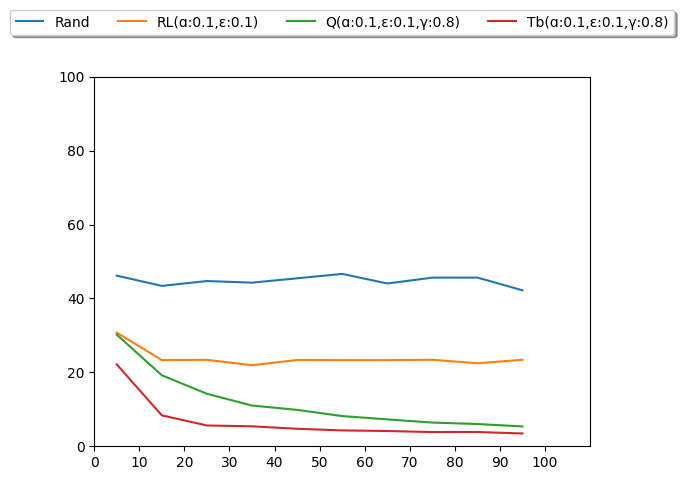

In [11]:
# plot results
plt.ylim(0, MAX_STEPS)
plt.xlim(-0.5,BINS+0.5)
plt.xticks(np.arange(BINS+1)-0.5, np.arange(0,RUNS+1,RUNS/BINS,int))

for i in range(len(agents)):
    plt.plot(scores[i], label = agents[i].label())

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=4, fancybox=True, shadow=True)


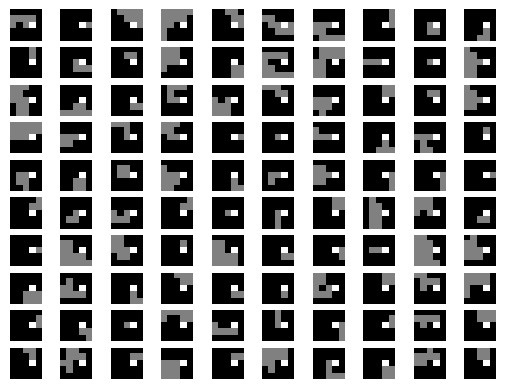

In [12]:
showSampleRuns(RL(ACTIONS,.1,.1), (5,5), 100)

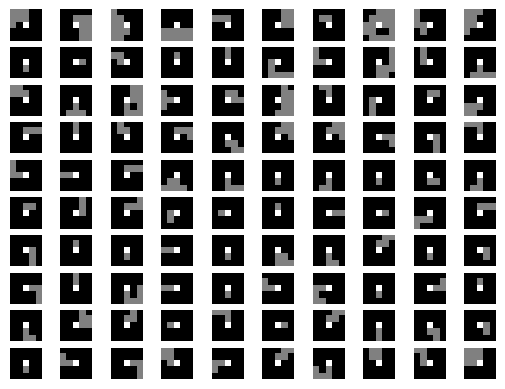

In [13]:
showSampleRuns(QRL(ACTIONS,.1,.1,.8), (5,5), 100)

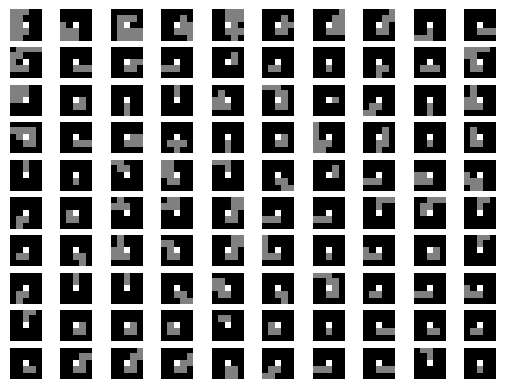

In [14]:
showSampleRuns(TracebackRL(ACTIONS,.1,.1,.8), (5,5), 100)